In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from jiwer import wer
from IPython import display
from datetime import datetime

now = datetime.now()
dt = now.strftime("%Y%m%d.%H%M%S")
print (dt)

2022-09-17 01:49:19.980607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 01:49:20.150047: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-17 01:49:20.207220: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-17 01:49:21.158575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

20220917.014922


In [2]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ013-0193,"Courvoisier, when put on his trial, pleaded no..."
1,LJ015-0091,and to have succeeded in other speculations.
2,LJ004-0097,to provide such accommodations in jails as may...


In [3]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


In [4]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


2022-09-17 01:49:22.973382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 01:49:27.163064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22548 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:07.0, compute capability: 7.0
2022-09-17 01:49:27.165218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22546 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:08.0, compute capability: 7.0
2022-09-17 01:49:27.167483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/rep

In [5]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [6]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

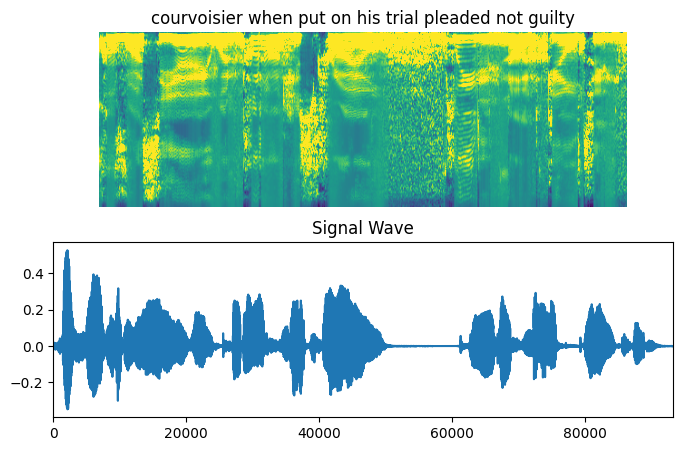

In [7]:
ig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [8]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [9]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [10]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [ ]:
# Define the number of epochs.
epochs = 50
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/50


2022-09-17 01:49:51.218639: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 4s 4s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : but mrs manning speaking in a foreign accent addressed the court with great fluency and vehemence
Prediction: ss
----------------------------------------------------------------------------------------------------
Target    : the inspector said that they could not be removed till he reached england
Prediction: s
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 1138s 3s/step - loss: 298.5206 - val_loss: 281.7130
Epoch 2/50
1/1 [==============================] - 1s 571ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.8665
-------------

----------------------------------------------------------------------------------------------------
Word Error Rate: 0.7845
----------------------------------------------------------------------------------------------------
Target    : framing a terrible indictment against those responsible for the condition of newgate their words deserve to be quoted in full
Prediction: framming a terablan dy etgenhos responibl fo i condiion of nga the wors diser to be coted in fl
----------------------------------------------------------------------------------------------------
Target    : thus when the inspectors visited there were twentythree strangers and only twentyeight prisoners
Prediction: thous wan the ins pectrs visited ther wheh enty toe strangurs ad o lytwent a prisoner
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 681s 2s/step - loss: 138.0185 - val_loss: 115.0924
Epoch 4/50
1/1 [=========

1/1 [==============================] - 1s 649ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.5718
----------------------------------------------------------------------------------------------------
Target    : the disassembled rifle was too long to be carried in this manner
Prediction: the disessembled rifle was to lone to be carid in this manar
----------------------------------------------------------------------------------------------------
Target    : the want of sleeping cells long continued a crying need
Prediction: the wont of slepingcels long continur crinne
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 693s 2s/step - loss: 82.3418 - val_loss: 75.6938
Epoch 7/50
1/1 [==============================] - 1s 623ms/step
----------------------------------------------------------------------------------------

Epoch 9/50
1/1 [==============================] - 1s 837ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4569
----------------------------------------------------------------------------------------------------
Target    : meanwhile on november seventeen
Prediction: in wile on novever seventeen
----------------------------------------------------------------------------------------------------
Target    : mr gee of bishop stortford who administered the estate of a certain mr canning deceased
Prediction: mrd g of bissop stor ford who adminired the istate of a certin mr caning diceas
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 692s 2s/step - loss: 60.0716 - val_loss: 61.5620
Epoch 10/50
1/1 [==============================] - 1s 607ms/step
--------------------------------------------------------------------------

1/1 [==============================] - 1s 647ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3951
----------------------------------------------------------------------------------------------------
Target    : frazier testified that while he could not tell when the defect occurred but that a person familiar with the weapon could compensate for it
Prediction: fraziur testified that whaite he could not tel wen the defecte curd but that persson fomnili with the weapon could compen site for it
----------------------------------------------------------------------------------------------------
Target    : but at various dates treason more distinct and tangible came to the front attempts to levy war against the state
Prediction: but at various dates trees in mor destant and tanguable came to the front attempts to levy war against the stat
--------------------------------------------------------------------------

1/1 [==============================] - 1s 791ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3375
----------------------------------------------------------------------------------------------------
Target    : to deeds involving on the whole some three hundred fifty thousand pounds
Prediction: to deds involding on the whole some three hundred tfifty thousand pounds
----------------------------------------------------------------------------------------------------
Target    : it was customary to make the executioner take the bible in his hand and swear solemnly that he would dispatch every criminal condemned to die
Prediction: it was coustimary to make the executioner take the bible in his hand and swhere solomly that he would dispach every criminal condemed to die
----------------------------------------------------------------------------------------------------
369/369 [==============================] -

1/1 [==============================] - 1s 597ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3070
----------------------------------------------------------------------------------------------------
Target    : monitor or schoolmaster nor to be engaged in the service of any officer of the prison
Prediction: moniter or school master nor to be engaged in the service of any officer of the prison
----------------------------------------------------------------------------------------------------
Target    : backed up by the evidence of several influential witnesses
Prediction: backed up by the evidence of several influential witnesses
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 692s 2s/step - loss: 35.8284 - val_loss: 50.5076
Epoch 17/50
1/1 [==============================] - 1s 544ms/step
-----------------------

1/1 [==============================] - 1s 621ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2821
----------------------------------------------------------------------------------------------------
Target    : yet it must have been abundantly plain to the reader that the other evils existing were great and glaring a brief summary of them will best prove this
Prediction: gyest it must have been abundedtly plaine to the reader that the other evls existing were great and  glaring a brief summery   
----------------------------------------------------------------------------------------------------
Target    : truly estimated that he gave this information to fritz about fifteen or twenty minutes after the shots
Prediction: truly estimated that he gade his information to frits a bout fifteen ar twenty minutes after the shots
---------------------------------------------------------------------------------------

Epoch 22/50
1/1 [==============================] - 1s 617ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2466
----------------------------------------------------------------------------------------------------
Target    : with the assistance of agent in charge sorrels of the dallas field office of the secret service
Prediction: with the assistance uf agentin charge sorols of the dallasfield office of the secret service
----------------------------------------------------------------------------------------------------
Target    : the commission does believe that there are aspects of the protective measures employed in the motorcade at dallas which deserve special comment
Prediction: the commission dos believe that there are aspects of the protective measures employed in the motorcade a dallas which deserve special comment
-------------------------------------------------------------------------------------

1/1 [==============================] - 1s 560ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2342
----------------------------------------------------------------------------------------------------
Target    : he said that nothing kept him in the united states that he would not lose anything if he returned to the soviet union that he wanted to be with her
Prediction: he said that nothing kept im in the united states that he would not les anything if pe returned to the soviet union that he wanted to be with her
----------------------------------------------------------------------------------------------------
Target    : brennan saw a man in the window who closely resembled lee harvey oswald and that brennan believes the man he saw was in fact
Prediction: brennand saw a man in the window who closely resembled lee harvey oswald and that bren an believes the man he saw was in fact
---------------------------

1/1 [==============================] - 1s 637ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2147
----------------------------------------------------------------------------------------------------
Target    : in view of his experiences when he visited his relatives in new orleans in the spring of nineteen fifty and his other solitary habits
Prediction: int view of his experiences when he visited his relatives in new orleans the spring of nineteen fifty and his other solitary habits
----------------------------------------------------------------------------------------------------
Target    : one narrow escape he had however before he abandoned his old business
Prediction: one narow escape he had however before he abandoned his old business
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 689s 2s/step - loss: 20

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

In [ ]:
filename = "models/asr-{}-{}.h5".format(epochs, dt)
print(filename)
#model.save('asr-50.h5')
model.save(filename)